In [1]:
  import frozen_lake as fl
  import numpy as np
  from collections import defaultdict
  import matplotlib.pyplot as plt
  import collections
  import pandas as pd


In [2]:
env = fl.FrozenLakeEnv(map_name="4x4-easy", slip_rate=0)

In [3]:
def generate_episode(policy, env, render):
    state = env.reset()
    done = False
    episodes = []
    while not done:
        if render:
            env.render()
        action = np.random.choice(np.arange(4), p=policy[state,:])
        next_state, reward, done, extra = env.step(action)
        episodes.append((state, action, reward))
        state = next_state
    
    return episodes

In [4]:
#policy
policy= 1/4 * np.ones((16,4))

In [5]:
def every_visit_mc(policy, episode_n, gamma, env):
    #initialize
    V = np.zeros(env.observation_space.n)
    returns = collections.defaultdict(list)
    V_hist = np.zeros((10000, 16))
    
    for i in range(episode_n):

        
        episodes = generate_episode(policy, env, False)
        G = 0
        for t in range(len(episodes))[::-1]:
            state, action, reward = episodes[t]
            G = gamma * G + reward
            returns[state].append(G)
            V[state] = np.average(returns[state])
        

        V_hist[i,:] = V.copy()

    return V, V_hist


In [6]:
V, V_hist = every_visit_mc(policy, 10000, 0.99, env)

### 2.1.a

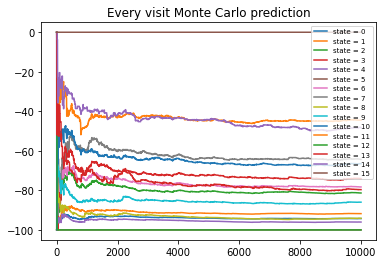

In [7]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("Every visit Monte Carlo prediction")

plt.show()

### 2.1.b

In [36]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))


╒════════════╤════════════╤════════════╤════════════╕
│ S -94.27   │ F -92.27   │ F -82.22   │ F -74.14   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -96.26   │ H -100.0   │ F -78.81   │ F -64.22   │
├────────────┼────────────┼────────────┼────────────┤
│ F -93.71   │ F -84.17   │ F -64.57   │ F -44.58   │
├────────────┼────────────┼────────────┼────────────┤
│ H -100.0   │ F -75.47   │ F -47.34   │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


# 2.2

In [8]:
def generate_episode_TD(policy, env, render):
    state = env.reset()
    done = False
    episodes = []
    while not done:
        if render:
            env.render()
        action = np.random.choice(np.arange(4), p=policy[state,:])
        next_state, reward, done, extra = env.step(action)
        episodes.append((state, next_state, action, reward, done))
        state = next_state
    
    return episodes

In [9]:
def td_0(policy, alpha, episode_n, gamma):
    V = np.zeros(16)
    V_hist = np.zeros((10000, 16))


    for i in range(episode_n):

        episodes = generate_episode_TD(policy, env, False)
        for t in range(len(episodes)):
            state, next_state, action, reward, done = episodes[t]
            if done:
                V[state] = V[state] + alpha * (reward + gamma * 0 - V[state])
            else:
              V[state] = V[state] + alpha * (reward + gamma * V[next_state] - V[state])
      
        V_hist[i,:] = V.copy()
    
    return V_hist, V
      

In [10]:
V_hist, V = td_0(policy, 0.01, 10000, 0.99)

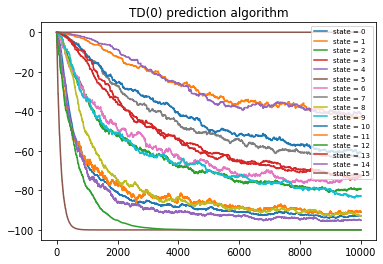

In [11]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("TD(0) prediction algorithm")
plt.show()

In [12]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))


╒════════════╤════════════╤════════════╤════════════╕
│ S -92.84   │ F -90.88   │ F -79.28   │ F -72.32   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -95.11   │ H -100.0   │ F -73.41   │ F -63.29   │
├────────────┼────────────┼────────────┼────────────┤
│ F -92.79   │ F -82.75   │ F -60.7    │ F -43.25   │
├────────────┼────────────┼────────────┼────────────┤
│ H -100.0   │ F -72.78   │ F -41.3    │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


### 2.3

In [13]:
def n_stepTD(policy, alpha, episode_n, n, gamma):

    V = np.zeros(16)
    V_hist = np.zeros((10000, 16))  


    for i in range(episode_n):
        state = env.reset()
        T = np.inf
        t=0
        reward_ = []
        state_ = [state]
        while True:
            if t < T:
                action = np.random.choice(np.arange(4), p=policy[state,:])
                next_state, reward, done, extra = env.step(action)
                reward_.append(reward)
                state_.append(next_state)
                state = next_state
                if done:
                    T = t + 1
            
            tau = t - n + 1
            if tau >= 0:

                G = sum(gamma**(i - tau) * reward_[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    state_taun =  state_[tau+n]  
                    G += gamma**n * V[state_taun]
                state_tau = state_[tau]  
                V[state_tau] += alpha * (G - V[state_tau])

            
            t += 1
            if tau == T - 1:
                break

        
        V_hist[i,:] = V.copy()

   
    return V_hist, V

In [14]:
V_hist, V = n_stepTD(policy, 0.01, 10000, 1, 0.99)

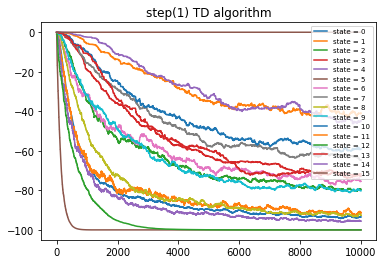

In [16]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("step(1) TD algorithm")
plt.show()

In [17]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))


╒════════════╤════════════╤════════════╤════════════╕
│ S -93.41   │ F -91.22   │ F -79.62   │ F -72.83   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -95.5    │ H -100.0   │ F -75.42   │ F -64.62   │
├────────────┼────────────┼────────────┼────────────┤
│ F -92.48   │ F -80.19   │ F -59.02   │ F -40.87   │
├────────────┼────────────┼────────────┼────────────┤
│ H -100.0   │ F -71.68   │ F -44.79   │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


### 2.4

In [18]:
V_hist, V = n_stepTD(policy, 0.01, 10000, 100, 0.99)

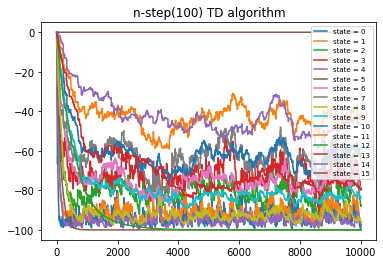

In [19]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.title("n-step(100) TD algorithm")

plt.show()

In [20]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))


╒════════════╤════════════╤════════════╤════════════╕
│ S -97.59   │ F -95.92   │ F -87.62   │ F -79.27   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -97.37   │ H -100.0   │ F -78.85   │ F -61.52   │
├────────────┼────────────┼────────────┼────────────┤
│ F -95.72   │ F -83.62   │ F -61.17   │ F -42.66   │
├────────────┼────────────┼────────────┼────────────┤
│ H -100.0   │ F -79.76   │ F -46.85   │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛


### 2.5

In [21]:
def n_stepTD(policy, alpha, episode_n, n, gamma):

    V = np.zeros(16)
    V_hist = np.zeros((10000, 16))
    c = np.zeros(16)
  


    for i in range(episode_n):
        state = env.reset()
        T = np.inf
        t=0
        reward_ = []
        state_ = [state]
        while True:
            if t < T:
                action = np.random.choice(np.arange(4), p=policy[state,:])
                next_state, reward, done, extra = env.step(action)
                reward_.append(reward)
                state_.append(next_state)
                state = next_state
                if done:
                    T = t + 1
            
            tau = t - n + 1
            if tau >= 0:

                G = sum(gamma**(i - tau) * reward_[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    state_taun =  state_[tau+n]  
                    G += gamma**n * V[state_taun]
                state_tau = state_[tau]
                c[state_[(tau)%(n+1)]]+=1
                alpha=1/c[state_[(tau)%(n+1)]] 
                V[state_tau] += alpha * (G - V[state_tau])

            
            t += 1
            if tau == T - 1:
                break

        
        V_hist[i,:] = V.copy()

   
    return V_hist, V

In [22]:
V_hist, V = n_stepTD(policy, 0.01, 10000, 100, 0.99)

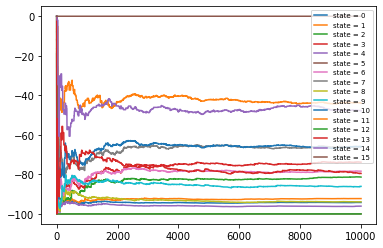

In [23]:
for i in range(16):
  plt.plot(V_hist[:,i], label = f"state = {i}")
plt.legend(loc=1, fontsize = 'x-small')
plt.show()



In [24]:
from tabulate import tabulate
print(tabulate({f'S {round(V[0],2)}': [f'F {round(V[4],2)}', f'F {round(V[8],2)}', f'H {round(V[12],2)}'], f'F {round(V[1],2)}': [f'H {round(V[5],2)}', f'F {round(V[9],2)}', f'F {round(V[13],2)}'], f'F {round(V[2],2)}': [f'F {round(V[6],2)}', f'F {round(V[10],2)}', f'F {round(V[14],2)}'], f'F {round(V[3],2)}':[f'F {round(V[7],2)}',f'F {round(V[11],2)}',f'G {round(V[15],2)}'],}, headers="keys", tablefmt='fancy_grid', missingval='N/A'))


╒════════════╤════════════╤════════════╤════════════╕
│ S -94.21   │ F -92.24   │ F -81.36   │ F -73.83   │
╞════════════╪════════════╪════════════╪════════════╡
│ F -96.07   │ H -100.0   │ F -78.38   │ F -66.1    │
├────────────┼────────────┼────────────┼────────────┤
│ F -93.88   │ F -86.07   │ F -65.94   │ F -44.01   │
├────────────┼────────────┼────────────┼────────────┤
│ H -100.0   │ F -79.53   │ F -47.87   │ G 0.0      │
╘════════════╧════════════╧════════════╧════════════╛
